In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import Input, Dense, SimpleRNN
from sklearn.model_selection import GridSearchCV, train_test_split

#### Data Model Implementation (25 points)

In [4]:
# The model utilizes data retrieved from SQL or Spark (5 points)
# read table tesla from stock_db
df = pd.read_sql('SELECT * FROM msft', db, index_col='Date')
df[:5]

In [16]:
# df = pd.read_csv('msft_data.csv')
# df[:5]

,Date,Open,High,Low,Close,Recomendation
0,2023-09-20 Wed,327.055125,327.134516,318.122176,318.380219,Sell
1,2023-09-21 Thu,316.881498,322.926123,312.653225,317.149475,Buy
2,2023-09-22 Fri,318.926111,319.055147,313.794615,314.648224,Sell
3,2023-09-25 Mon,314.231351,315.303322,312.653201,315.174286,Sell
4,2023-09-26 Tue,312.782259,313.526672,307.710313,309.814545,Sell


In [24]:
# dropped the first three rows to start the data collection on a Monday.
df = df[3:].copy()
df[:5]

,Date,Open,High,Low,Close,Recomendation
3,2023-09-25 Mon,314.231351,315.303322,312.653201,315.174286,Sell
4,2023-09-26 Tue,312.782259,313.526672,307.710313,309.814545,Sell
5,2023-09-27 Wed,309.973286,311.958385,307.382745,310.459656,Sell
6,2023-09-28 Thu,308.673063,313.129633,307.144558,311.303345,Buy
7,2023-09-29 Fri,315.382713,317.089900,312.633361,313.397614,Sell


In [25]:
# Generating labels. Since I'm generating a label based on the next day's information, I need to have one less label.
print("Generating labels. Since I'm generating a label based on the next day's information, I need to have one less label.")
print(f'rows on dataframe: {len(df)}')

labels = []
for i in range(len(df)-1):
    today = df.iloc[i]
    tomorrow = df.iloc[i+1]

    if today.Open<tomorrow.Open:
        labels.append('Buy')
    else:
        labels.append('Sell')

print(f'Count of labels: {len(labels)}')

Generating labels. Since I'm generating a label based on the next day's information, I need to have one less label.
rows on dataframe: 245
Count of labels: 244


In [28]:
# A Python script initializes, trains, and evaluates a model (10 points)
# I need to drop last row of data so labels can match
df = df[:-1].copy()

# Adding labels to dataframe
df['Recomendation'] = labels

# displaying dataframe
df

In [47]:
# The data is cleaned, normalized, and standardized prior to modeling (5 points)
# splitting data into X and y
X = df.drop(['Date','Recomendation'],axis=1).values
y = df.Recomendation.values

In [49]:
print(len(X))
print(X[:5])
print()
print(len(y))
print(y[:5])

245
[[314.23135142 315.30332221 312.6532008  315.17428589]
 [312.78225923 313.52667166 307.71031342 309.81454468]
 [309.97328577 311.95838534 307.38274537 310.45965576]
 [308.67306343 313.12963279 307.1445585  311.30334473]
 [315.38271322 317.08990016 312.63336105 313.39761353]]

245
['Sell' 'Sell' 'Sell' 'Buy' 'Sell']


In [50]:
# Tokenizing labels
y = [ 1 if v=='Sell' else 0 for v in y]
print(len(y))
y[:5]

245


[1, 1, 1, 0, 1]

In [51]:
# Split data into training and validation
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [52]:
# The model demonstrates meaningful predictive power at least 75%
# classification accuracy or 0.80 R-squared. (5 points)

model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [53]:
# Prediction score
f'The validation accuracy score of {model.score(X_test,y_test)*100:.2f}% does not meet standards.'

'The validation accuracy score of 32.29% does not meet standards.'

#### Data Model Optimization (25 points)

In [55]:
# creating new labels
new_y = [ 'Buy' if x>=0 else 'Sell' for x in df.Close - df.Open]
new_y[:5]

['Buy', 'Sell', 'Buy', 'Buy', 'Sell']

In [56]:
X[:5]

array([[314.23135142, 315.30332221, 312.6532008 , 315.17428589],
       [312.78225923, 313.52667166, 307.71031342, 309.81454468],
       [309.97328577, 311.95838534, 307.38274537, 310.45965576],
       [308.67306343, 313.12963279, 307.1445585 , 311.30334473],
       [315.38271322, 317.08990016, 312.63336105, 313.39761353]])

In [57]:
new_y = [1 if x=='Sell' else 0 for x in new_y]

In [58]:
# Split data into training and validation
X_train, X_test, y_train, y_test = train_test_split(X,new_y)

In [59]:
model2 = LinearRegression()
model2.fit(X_train,y_train)

LinearRegression()

In [60]:
model2.score(X_train,y_train)

0.6067637660638876

### The linear model was not good enough.  I'm trying a Recurrent Neural Network

In [62]:
df = pd.read_csv('msft_data.csv', index_col='Date')
df = df[3:].copy()
df[:5]

,Open,High,Low,Close,Recomendation
Date,,,,,
2023-09-25 Mon,314.231351,315.303322,312.653201,315.174286,Sell
2023-09-26 Tue,312.782259,313.526672,307.710313,309.814545,Sell
2023-09-27 Wed,309.973286,311.958385,307.382745,310.459656,Sell
2023-09-28 Thu,308.673063,313.129633,307.144558,311.303345,Buy
2023-09-29 Fri,315.382713,317.089900,312.633361,313.397614,Sell


In [63]:
df.drop('Recomendation', axis=1, inplace=True)

In [64]:
# reshape the data to create a 5 time step recurrency
msft_data = np.array(df).reshape(-1,5,4)

In [67]:
msft_data[:2]

array([[[314.23135142, 315.30332221, 312.6532008 , 315.17428589],
        [312.78225923, 313.52667166, 307.71031342, 309.81454468],
        [309.97328577, 311.95838534, 307.38274537, 310.45965576],
        [308.67306343, 313.12963279, 307.1445585 , 311.30334473],
        [315.38271322, 317.08990016, 312.63336105, 313.39761353]],

       [[313.92369263, 319.49191352, 312.83188164, 319.40255737],
        [318.43974918, 318.99560495, 308.89142465, 311.0552063 ],
        [311.69044595, 317.65568058, 311.66067066, 316.58370972],
        [316.71273533, 317.59611926, 312.55394894, 316.98071289],
        [314.19166787, 326.73751351, 313.94353038, 324.82189941]]])

In [70]:
# Creating labels for the five days recurrency.
new_labels = []

for x in msft_data:
  open_mon = x[0][0]
  close_fri = x[-1][-1]

  if close_fri < open_mon:
    new_labels.append('Sell')
  else:
    new_labels.append('Buy')

In [72]:
new_labels[:5]

['Sell', 'Buy', 'Buy', 'Sell', 'Buy']

In [73]:
# # Tokenizing the labels to a binary vector
# y = [ [1,0] if x == 'Sell' else [0,1] for x in new_labels]

In [102]:
# Tokenizing the labels to a binary vector
y = [ 1 if x == 'Sell' else 0 for x in new_labels]

In [103]:
y[:5]

[1, 0, 0, 1, 0]

In [104]:
# turning y to a numpy array
y = np.array(y)

In [105]:
y.shape

(49,)

In [106]:
msft_data.shape

(49, 5, 4)

In [112]:
import matplotlib.pyplot as plt

In [120]:
df.index

RangeIndex(start=0, stop=10, step=1)

In [122]:
df

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.333333,0.668123,0.8,0.759811,1
1,0.333333,0.664472,0.8,0.760555,2
2,0.333333,0.663674,0.8,0.767540,3
3,0.333333,0.661553,0.8,0.773178,4
4,0.333333,0.660146,0.8,0.773431,5
5,0.333333,0.659779,0.8,0.777347,6
6,0.333333,0.658632,0.8,0.781402,7
7,0.333333,0.657465,0.8,0.786894,8
8,0.333333,0.656308,0.8,0.787063,9
9,0.333333,0.656132,0.8,0.788735,10


Model: "sequential_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_372 (SimpleRNN)           │ (None, 5, 1)                │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_373 (SimpleRNN)           │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11 (44.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.3472 - loss: 0.6930 - val_accuracy: 0.8000 - val_loss: 0.6950
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3472 - loss: 0.6922 - val_accuracy: 0.8000 - val_loss: 0.6960
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3368 - loss: 0.6916 - val_accuracy: 0.8000 - val_loss: 0.6967
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3160 - loss: 0.6910 - val_accuracy: 0.8000 - val_loss: 0.6969
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3160 - loss: 0.6909 - val_accuracy: 0.8000 - val_loss: 0.6972
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3472 - loss: 0.6911 - val_accuracy: 0.8000 - val_loss: 0.6980
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3368 - loss: 0.6906 - val_accuracy: 0.8000 - val_loss: 0.6986
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3160 - loss: 0.6899 - val_accuracy: 0.8000 - val_loss: 0.6988
Epoch 9/10

Model: "sequential_123"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_374 (SimpleRNN)           │ (None, 5, 1)                │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_375 (SimpleRNN)           │ (None, 5, 1)                │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_376 (SimpleRNN)           │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 484ms/step - accuracy: 0.3472 - loss: 0.6930 - val_accuracy: 0.8000 - val_loss: 0.6950
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3264 - loss: 0.6921 - val_accuracy: 0.8000 - val_loss: 0.6956
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3160 - loss: 0.6917 - val_accuracy: 0.8000 - val_loss: 0.6959
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3264 - loss: 0.6915 - val_accuracy: 0.8000 - val_loss: 0.6965
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3264 - loss: 0.6912 - val_accuracy: 0.8000 - val_loss: 0.6971
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3368 - loss: 0.6910 - val_accuracy: 0.8000 - val_loss: 0.6978
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3368 - loss: 0.6906 - val_accuracy: 0.8000 - val_loss: 0.6986
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3472 - loss: 0.6904 - val_accuracy: 0.8000 - val_loss: 0.6994
Epoch 9/10

Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_377 (SimpleRNN)           │ (None, 5, 1)                │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_378 (SimpleRNN)           │ (None, 5, 1)                │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_379 (SimpleRNN)           │ (None, 5, 1)                │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_380 (SimpleRNN)           │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 589ms/step - accuracy: 0.3472 - loss: 0.6930 - val_accuracy: 0.8000 - val_loss: 0.6950
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3160 - loss: 0.6920 - val_accuracy: 0.8000 - val_loss: 0.6953
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3160 - loss: 0.6918 - val_accuracy: 0.8000 - val_loss: 0.6956
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3368 - loss: 0.6918 - val_accuracy: 0.8000 - val_loss: 0.6964
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3472 - loss: 0.6915 - val_accuracy: 0.8000 - val_loss: 0.6973
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3576 - loss: 0.6912 - val_accuracy: 0.8000 - val_loss: 0.6981
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3160 - loss: 0.6902 - val_accuracy: 0.8000 - val_loss: 0.6983
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3576 - loss: 0.6907 - val_accuracy: 0.8000 - val_loss: 0.6990
Epoch 9/10

Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_381 (SimpleRNN)           │ (None, 5, 2)                │              14 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_382 (SimpleRNN)           │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_120 (Dense)                    │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27 (108.00 B)

 Trainable params: 27 (108.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - accuracy: 0.3368 - loss: 8.5105 - val_accuracy: 0.8000 - val_loss: 18.8680
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3368 - loss: 7.1516 - val_accuracy: 0.8000 - val_loss: 16.6821
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3160 - loss: 5.9019 - val_accuracy: 0.8000 - val_loss: 14.6237
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3264 - loss: 5.3381 - val_accuracy: 0.8000 - val_loss: 13.2157
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3264 - loss: 4.8734 - val_accuracy: 0.8000 - val_loss: 12.0463
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3264 - loss: 4.4065 - val_accuracy: 0.8000 - val_loss: 10.9682
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3576 - loss: 4.4206 - val_accuracy: 0.8000 - val_loss: 10.4318
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3368 - loss: 3.9425 - val_accuracy: 0.8000 - val_loss: 9.6046
Epo

Model: "sequential_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_383 (SimpleRNN)           │ (None, 5, 2)                │              14 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_384 (SimpleRNN)           │ (None, 5, 2)                │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_385 (SimpleRNN)           │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_121 (Dense)                    │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step - accuracy: 0.3264 - loss: 225.2517 - val_accuracy: 0.8000 - val_loss: 525.6245
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3264 - loss: 195.9910 - val_accuracy: 0.8000 - val_loss: 478.0258
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3368 - loss: 184.4947 - val_accuracy: 0.8000 - val_loss: 445.4247
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3264 - loss: 166.7551 - val_accuracy: 0.8000 - val_loss: 412.1920
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3368 - loss: 158.2213 - val_accuracy: 0.8000 - val_loss: 386.0552
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3264 - loss: 144.0760 - val_accuracy: 0.8000 - val_loss: 358.6248
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3472 - loss: 142.8620 - val_accuracy: 0.8000 - val_loss: 341.0547
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3576 - loss: 139.9758 - val_accuracy: 0.8000

Model: "sequential_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_386 (SimpleRNN)           │ (None, 5, 2)                │              14 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_387 (SimpleRNN)           │ (None, 5, 2)                │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_388 (SimpleRNN)           │ (None, 5, 2)                │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_389 (SimpleRNN)           │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_122 (Dense)                    │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47 (188.00 B)

 Trainable params: 47 (188.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 588ms/step - accuracy: 0.3160 - loss: 0.6932 - val_accuracy: 0.8000 - val_loss: 0.6938
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3264 - loss: 0.6928 - val_accuracy: 0.8000 - val_loss: 0.6947
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3264 - loss: 0.6923 - val_accuracy: 0.8000 - val_loss: 0.6954
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3472 - loss: 0.6919 - val_accuracy: 0.8000 - val_loss: 0.6965
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3368 - loss: 0.6913 - val_accuracy: 0.8000 - val_loss: 0.6972
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3472 - loss: 0.6911 - val_accuracy: 0.8000 - val_loss: 0.6981
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3160 - loss: 0.6902 - val_accuracy: 0.8000 - val_loss: 0.6983
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3264 - loss: 0.6902 - val_accuracy: 0.8000 - val_loss: 0.6987
Epoch 9/10

Model: "sequential_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_390 (SimpleRNN)           │ (None, 5, 3)                │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_391 (SimpleRNN)           │ (None, 3)                   │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_123 (Dense)                    │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49 (196.00 B)

 Trainable params: 49 (196.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.3264 - loss: 54.2928 - val_accuracy: 0.8000 - val_loss: 135.8309
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3264 - loss: 51.0792 - val_accuracy: 0.8000 - val_loss: 130.8251
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3576 - loss: 53.9697 - val_accuracy: 0.8000 - val_loss: 128.5760
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3160 - loss: 46.7810 - val_accuracy: 0.8000 - val_loss: 124.3763
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3368 - loss: 48.2216 - val_accuracy: 0.8000 - val_loss: 121.5912
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3160 - loss: 44.5304 - val_accuracy: 0.8000 - val_loss: 118.2580
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3264 - loss: 44.5590 - val_accuracy: 0.8000 - val_loss: 115.5486
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3264 - loss: 43.2475 - val_accuracy: 0.8000 - val_l

Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_392 (SimpleRNN)           │ (None, 5, 3)                │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_393 (SimpleRNN)           │ (None, 5, 3)                │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_394 (SimpleRNN)           │ (None, 3)                   │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_124 (Dense)                    │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70 (280.00 B)

 Trainable params: 70 (280.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - accuracy: 0.3264 - loss: 19.2161 - val_accuracy: 0.8000 - val_loss: 35.3466
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3160 - loss: 12.5428 - val_accuracy: 0.8000 - val_loss: 25.0856
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3160 - loss: 8.8001 - val_accuracy: 0.8000 - val_loss: 17.2989
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3368 - loss: 6.5857 - val_accuracy: 0.8000 - val_loss: 12.4083
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3368 - loss: 4.6823 - val_accuracy: 0.8000 - val_loss: 7.6276
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3368 - loss: 2.8371 - val_accuracy: 0.8000 - val_loss: 2.9850
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3264 - loss: 1.0575 - val_accuracy: 0.8000 - val_loss: 0.6972
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3264 - loss: 0.6905 - val_accuracy: 0.8000 - val_loss: 0.7593
Epoc

Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_395 (SimpleRNN)           │ (None, 5, 3)                │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_396 (SimpleRNN)           │ (None, 5, 3)                │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_397 (SimpleRNN)           │ (None, 5, 3)                │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_398 (SimpleRNN)           │ (None, 3)                   │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_125 (Dense)                    │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91 (364.00 B)

 Trainable params: 91 (364.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 626ms/step - accuracy: 0.3056 - loss: 417.0131 - val_accuracy: 0.8000 - val_loss: 111.0815
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3264 - loss: 350.6388 - val_accuracy: 0.8000 - val_loss: 99.8170
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3368 - loss: 310.2967 - val_accuracy: 0.8000 - val_loss: 90.9568
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3576 - loss: 272.4286 - val_accuracy: 0.8000 - val_loss: 82.8115
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3264 - loss: 259.5485 - val_accuracy: 0.8000 - val_loss: 77.0006
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3576 - loss: 229.6888 - val_accuracy: 0.8000 - val_loss: 70.7536
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3264 - loss: 220.9946 - val_accuracy: 0.8000 - val_loss: 66.1861
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3472 - loss: 199.2851 - val_accuracy: 0.8000 - val

Model: "sequential_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_399 (SimpleRNN)           │ (None, 5, 4)                │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_400 (SimpleRNN)           │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_126 (Dense)                    │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77 (308.00 B)

 Trainable params: 77 (308.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - accuracy: 0.3576 - loss: 142.0199 - val_accuracy: 0.8000 - val_loss: 336.7542
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3368 - loss: 130.9360 - val_accuracy: 0.8000 - val_loss: 327.2071
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3368 - loss: 126.4751 - val_accuracy: 0.8000 - val_loss: 319.3337
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3160 - loss: 116.5699 - val_accuracy: 0.8000 - val_loss: 311.1745
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3472 - loss: 124.1430 - val_accuracy: 0.8000 - val_loss: 306.6966
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3056 - loss: 108.0625 - val_accuracy: 0.8000 - val_loss: 299.6004
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3368 - loss: 115.7824 - val_accuracy: 0.8000 - val_loss: 295.2372
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3368 - loss: 113.9095 - val_accuracy: 0.8000

Model: "sequential_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_401 (SimpleRNN)           │ (None, 5, 4)                │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_402 (SimpleRNN)           │ (None, 5, 4)                │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_403 (SimpleRNN)           │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_127 (Dense)                    │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113 (452.00 B)

 Trainable params: 113 (452.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 482ms/step - accuracy: 0.3264 - loss: 0.6931 - val_accuracy: 0.8000 - val_loss: 0.6944
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3472 - loss: 0.6924 - val_accuracy: 0.8000 - val_loss: 0.6958
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3264 - loss: 0.6916 - val_accuracy: 0.8000 - val_loss: 0.6964
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3264 - loss: 0.6913 - val_accuracy: 0.8000 - val_loss: 0.6969
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3368 - loss: 0.6911 - val_accuracy: 0.8000 - val_loss: 0.6977
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3264 - loss: 0.6905 - val_accuracy: 0.8000 - val_loss: 0.6982
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3472 - loss: 0.6906 - val_accuracy: 0.8000 - val_loss: 0.6991
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3264 - loss: 0.6898 - val_accuracy: 0.8000 - val_loss: 0.6996
Epoch 9/10

Model: "sequential_133"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_404 (SimpleRNN)           │ (None, 5, 4)                │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_405 (SimpleRNN)           │ (None, 5, 4)                │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_406 (SimpleRNN)           │ (None, 5, 4)                │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_407 (SimpleRNN)           │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_128 (Dense)                    │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149 (596.00 B)

 Trainable params: 149 (596.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 856ms/step - accuracy: 0.3264 - loss: 3.2878 - val_accuracy: 0.8000 - val_loss: 2.2912
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3472 - loss: 1.3581 - val_accuracy: 0.8000 - val_loss: 7.5017
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3264 - loss: 2.6824 - val_accuracy: 0.8000 - val_loss: 0.3375
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3264 - loss: 1.5573 - val_accuracy: 0.8000 - val_loss: 0.3146
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3368 - loss: 0.9907 - val_accuracy: 0.8000 - val_loss: 0.3663
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3368 - loss: 0.7308 - val_accuracy: 0.8000 - val_loss: 0.9300
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3264 - loss: 0.6767 - val_accuracy: 0.8000 - val_loss: 0.3418
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3368 - loss: 1.3909 - val_accuracy: 0.8000 - val_loss: 1.2603
Epoch 9/10

Model: "sequential_134"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_408 (SimpleRNN)           │ (None, 5, 1)                │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_409 (SimpleRNN)           │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_129 (Dense)                    │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11 (44.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - accuracy: 0.3264 - loss: 0.8690 - val_accuracy: 0.8000 - val_loss: 0.5466
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3264 - loss: 0.8659 - val_accuracy: 0.8000 - val_loss: 0.5475
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3368 - loss: 0.8568 - val_accuracy: 0.8000 - val_loss: 0.5484
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3264 - loss: 0.8617 - val_accuracy: 0.8000 - val_loss: 0.5490
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3264 - loss: 0.8602 - val_accuracy: 0.8000 - val_loss: 0.5496
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3264 - loss: 0.8588 - val_accuracy: 0.8000 - val_loss: 0.5502
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3576 - loss: 0.8371 - val_accuracy: 0.8000 - val_loss: 0.5510
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3368 - loss: 0.8489 - val_accuracy: 0.8000 - val_loss: 0.5516
Epoch 9/10

Model: "sequential_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_410 (SimpleRNN)           │ (None, 5, 1)                │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_411 (SimpleRNN)           │ (None, 5, 1)                │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_412 (SimpleRNN)           │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_130 (Dense)                    │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 481ms/step - accuracy: 0.3472 - loss: 0.6689 - val_accuracy: 0.8000 - val_loss: 0.7566
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3160 - loss: 0.6620 - val_accuracy: 0.8000 - val_loss: 0.7569
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3472 - loss: 0.6679 - val_accuracy: 0.8000 - val_loss: 0.7585
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3264 - loss: 0.6633 - val_accuracy: 0.8000 - val_loss: 0.7592
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3472 - loss: 0.6672 - val_accuracy: 0.8000 - val_loss: 0.7606
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3368 - loss: 0.6647 - val_accuracy: 0.8000 - val_loss: 0.7616
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3472 - loss: 0.6665 - val_accuracy: 0.8000 - val_loss: 0.7630
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3368 - loss: 0.6639 - val_accuracy: 0.8000 - val_loss: 0.7639
Epoch 9/10

Model: "sequential_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_413 (SimpleRNN)           │ (None, 5, 1)                │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_414 (SimpleRNN)           │ (None, 5, 1)                │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_415 (SimpleRNN)           │ (None, 5, 1)                │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_416 (SimpleRNN)           │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_131 (Dense)                    │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 913ms/step - accuracy: 0.3368 - loss: 0.8860 - val_accuracy: 0.8000 - val_loss: 0.5377
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3264 - loss: 0.8895 - val_accuracy: 0.8000 - val_loss: 0.5386
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3264 - loss: 0.8870 - val_accuracy: 0.8000 - val_loss: 0.5394
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3472 - loss: 0.8695 - val_accuracy: 0.8000 - val_loss: 0.5403
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3472 - loss: 0.8672 - val_accuracy: 0.8000 - val_loss: 0.5411
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3368 - loss: 0.8726 - val_accuracy: 0.8000 - val_loss: 0.5418
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3472 - loss: 0.8635 - val_accuracy: 0.8000 - val_loss: 0.5425
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3472 - loss: 0.8618 - val_accuracy: 0.8000 - val_loss: 0.5432
Epoch 9/10

Model: "sequential_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_417 (SimpleRNN)           │ (None, 5, 2)                │              14 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_418 (SimpleRNN)           │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_132 (Dense)                    │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27 (108.00 B)

 Trainable params: 27 (108.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 0.3368 - loss: 0.6974 - val_accuracy: 0.8000 - val_loss: 1.3536
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3160 - loss: 0.6652 - val_accuracy: 0.8000 - val_loss: 1.3441
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3368 - loss: 0.6927 - val_accuracy: 0.8000 - val_loss: 1.3402
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3264 - loss: 0.6772 - val_accuracy: 0.8000 - val_loss: 1.3347
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3368 - loss: 0.6906 - val_accuracy: 0.8000 - val_loss: 1.3312
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3472 - loss: 0.7043 - val_accuracy: 0.8000 - val_loss: 1.3295
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3160 - loss: 0.6606 - val_accuracy: 0.8000 - val_loss: 1.3235
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3368 - loss: 0.6881 - val_accuracy: 0.8000 - val_loss: 1.3206
Epoch 9/10

Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_419 (SimpleRNN)           │ (None, 5, 2)                │              14 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_420 (SimpleRNN)           │ (None, 5, 2)                │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_421 (SimpleRNN)           │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_133 (Dense)                    │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step - accuracy: 0.3368 - loss: 0.6892 - val_accuracy: 0.8000 - val_loss: 0.7055
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3368 - loss: 0.6866 - val_accuracy: 0.8000 - val_loss: 0.7089
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3368 - loss: 0.6850 - val_accuracy: 0.8000 - val_loss: 0.7117
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3264 - loss: 0.6831 - val_accuracy: 0.8000 - val_loss: 0.7135
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3160 - loss: 0.6816 - val_accuracy: 0.8000 - val_loss: 0.7143
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3368 - loss: 0.6825 - val_accuracy: 0.8000 - val_loss: 0.7168
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3264 - loss: 0.6806 - val_accuracy: 0.8000 - val_loss: 0.7183
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3576 - loss: 0.6823 - val_accuracy: 0.8000 - val_loss: 0.7214
Epoch 9/10

Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_422 (SimpleRNN)           │ (None, 5, 2)                │              14 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_423 (SimpleRNN)           │ (None, 5, 2)                │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_424 (SimpleRNN)           │ (None, 5, 2)                │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_425 (SimpleRNN)           │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_134 (Dense)                    │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47 (188.00 B)

 Trainable params: 47 (188.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 575ms/step - accuracy: 0.3368 - loss: 0.6390 - val_accuracy: 0.8000 - val_loss: 0.9596
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3264 - loss: 0.6318 - val_accuracy: 0.8000 - val_loss: 0.9572
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3264 - loss: 0.6318 - val_accuracy: 0.8000 - val_loss: 0.9548
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3368 - loss: 0.6389 - val_accuracy: 0.8000 - val_loss: 0.9564
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3368 - loss: 0.6389 - val_accuracy: 0.8000 - val_loss: 0.9579
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3264 - loss: 0.6318 - val_accuracy: 0.8000 - val_loss: 0.9557
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3368 - loss: 0.6389 - val_accuracy: 0.8000 - val_loss: 0.9571
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3368 - loss: 0.6389 - val_accuracy: 0.8000 - val_loss: 0.9585
Epoch 9/10

Model: "sequential_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_426 (SimpleRNN)           │ (None, 5, 3)                │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_427 (SimpleRNN)           │ (None, 3)                   │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_135 (Dense)                    │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49 (196.00 B)

 Trainable params: 49 (196.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step - accuracy: 0.3264 - loss: 0.6465 - val_accuracy: 0.8000 - val_loss: 0.8224
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3368 - loss: 0.6494 - val_accuracy: 0.8000 - val_loss: 0.8292
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3368 - loss: 0.6483 - val_accuracy: 0.8000 - val_loss: 0.8343
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3264 - loss: 0.6434 - val_accuracy: 0.8000 - val_loss: 0.8358
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3264 - loss: 0.6431 - val_accuracy: 0.8000 - val_loss: 0.8372
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3264 - loss: 0.6428 - val_accuracy: 0.8000 - val_loss: 0.8386
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3368 - loss: 0.6468 - val_accuracy: 0.8000 - val_loss: 0.8428
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3576 - loss: 0.6551 - val_accuracy: 0.8000 - val_loss: 0.8473
Epoch 9/10

Model: "sequential_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_428 (SimpleRNN)           │ (None, 5, 3)                │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_429 (SimpleRNN)           │ (None, 5, 3)                │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_430 (SimpleRNN)           │ (None, 3)                   │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_136 (Dense)                    │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70 (280.00 B)

 Trainable params: 70 (280.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 625ms/step - accuracy: 0.3368 - loss: 0.7193 - val_accuracy: 0.8000 - val_loss: 0.6570
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3264 - loss: 0.7172 - val_accuracy: 0.8000 - val_loss: 0.6594
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3264 - loss: 0.7154 - val_accuracy: 0.8000 - val_loss: 0.6616
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3368 - loss: 0.7126 - val_accuracy: 0.8000 - val_loss: 0.6642
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3576 - loss: 0.7086 - val_accuracy: 0.8000 - val_loss: 0.6672
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3472 - loss: 0.7078 - val_accuracy: 0.8000 - val_loss: 0.6693
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3160 - loss: 0.7092 - val_accuracy: 0.8000 - val_loss: 0.6700
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3160 - loss: 0.7086 - val_accuracy: 0.8000 - val_loss: 0.6708
Epoch 9/10

Model: "sequential_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_431 (SimpleRNN)           │ (None, 5, 3)                │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_432 (SimpleRNN)           │ (None, 5, 3)                │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_433 (SimpleRNN)           │ (None, 5, 3)                │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_434 (SimpleRNN)           │ (None, 3)                   │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_137 (Dense)                    │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91 (364.00 B)

 Trainable params: 91 (364.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 623ms/step - accuracy: 0.3368 - loss: 0.6403 - val_accuracy: 0.8000 - val_loss: 1.0033
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3368 - loss: 0.6402 - val_accuracy: 0.8000 - val_loss: 1.0028
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3264 - loss: 0.6320 - val_accuracy: 0.8000 - val_loss: 0.9971
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3576 - loss: 0.6562 - val_accuracy: 0.8000 - val_loss: 0.9992
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3472 - loss: 0.6481 - val_accuracy: 0.8000 - val_loss: 1.0011
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3264 - loss: 0.6319 - val_accuracy: 0.8000 - val_loss: 0.9990
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3056 - loss: 0.6158 - val_accuracy: 0.8000 - val_loss: 0.9952
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3264 - loss: 0.6318 - val_accuracy: 0.8000 - val_loss: 0.9938
Epoch 9/10

Model: "sequential_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_435 (SimpleRNN)           │ (None, 5, 4)                │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_436 (SimpleRNN)           │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_138 (Dense)                    │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77 (308.00 B)

 Trainable params: 77 (308.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 562ms/step - accuracy: 0.3368 - loss: 0.8202 - val_accuracy: 0.8000 - val_loss: 0.5691
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3472 - loss: 0.8080 - val_accuracy: 0.8000 - val_loss: 0.5720
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3368 - loss: 0.8089 - val_accuracy: 0.8000 - val_loss: 0.5739
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3368 - loss: 0.8057 - val_accuracy: 0.8000 - val_loss: 0.5758
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3264 - loss: 0.8079 - val_accuracy: 0.8000 - val_loss: 0.5773
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3160 - loss: 0.8107 - val_accuracy: 0.8000 - val_loss: 0.5784
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3368 - loss: 0.7988 - val_accuracy: 0.8000 - val_loss: 0.5802
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3264 - loss: 0.8010 - val_accuracy: 0.8000 - val_loss: 0.5816
Epoch 9/10

Model: "sequential_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_437 (SimpleRNN)           │ (None, 5, 4)                │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_438 (SimpleRNN)           │ (None, 5, 4)                │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_439 (SimpleRNN)           │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_139 (Dense)                    │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113 (452.00 B)

 Trainable params: 113 (452.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - accuracy: 0.3472 - loss: 0.7218 - val_accuracy: 0.8000 - val_loss: 0.6562
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3368 - loss: 0.7163 - val_accuracy: 0.8000 - val_loss: 0.6614
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3264 - loss: 0.7139 - val_accuracy: 0.8000 - val_loss: 0.6649
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3264 - loss: 0.7113 - val_accuracy: 0.8000 - val_loss: 0.6684
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3368 - loss: 0.7078 - val_accuracy: 0.8000 - val_loss: 0.6731
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3264 - loss: 0.7056 - val_accuracy: 0.8000 - val_loss: 0.6764
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3368 - loss: 0.7027 - val_accuracy: 0.8000 - val_loss: 0.6809
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3264 - loss: 0.7005 - val_accuracy: 0.8000 - val_loss: 0.6840
Epoch 9/10

Model: "sequential_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_440 (SimpleRNN)           │ (None, 5, 4)                │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_441 (SimpleRNN)           │ (None, 5, 4)                │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_442 (SimpleRNN)           │ (None, 5, 4)                │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_443 (SimpleRNN)           │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_140 (Dense)                    │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149 (596.00 B)

 Trainable params: 149 (596.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 602ms/step - accuracy: 0.3264 - loss: 0.6720 - val_accuracy: 0.8000 - val_loss: 0.7414
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3368 - loss: 0.6711 - val_accuracy: 0.8000 - val_loss: 0.7476
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3368 - loss: 0.6689 - val_accuracy: 0.8000 - val_loss: 0.7523
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3368 - loss: 0.6673 - val_accuracy: 0.8000 - val_loss: 0.7564
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3368 - loss: 0.6660 - val_accuracy: 0.8000 - val_loss: 0.7601
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3472 - loss: 0.6669 - val_accuracy: 0.8000 - val_loss: 0.7643
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3264 - loss: 0.6613 - val_accuracy: 0.8000 - val_loss: 0.7659
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3160 - loss: 0.6585 - val_accuracy: 0.8000 - val_loss: 0.7663
Epoch 9/10

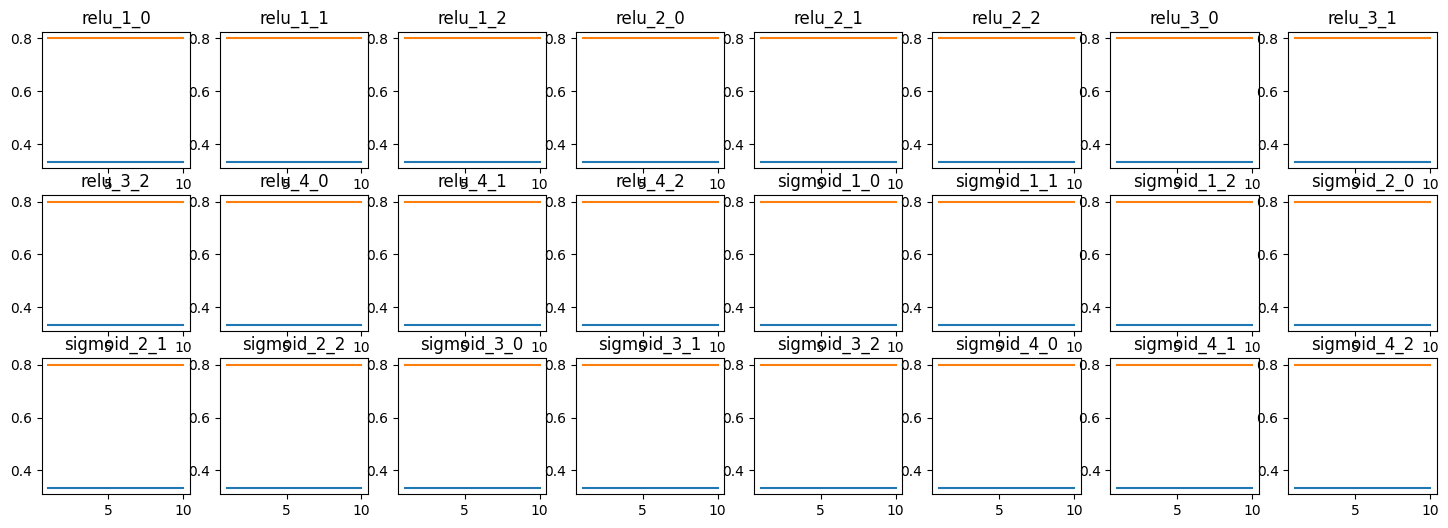

In [134]:
plot = 0
neurons = 4
h_layers = 3
acts = ['relu','sigmoid']

plt.figure(figsize = [18,6])

for act in acts:
  for n in range(1,neurons+1):
    for h_layer in range(h_layers):
      nn = Sequential()
      nn.add(Input(shape=(msft_data.shape[1],msft_data.shape[2])))

      for _ in range(h_layer+1):
        nn.add(SimpleRNN(n, activation=act, return_sequences=True))

      nn.add(SimpleRNN(n, activation=act, return_sequences=False))

      nn.add(Dense(1, activation='softmax'))

      nn.compile(loss='binary_crossentropy', metrics=['accuracy'])

      print(nn.summary())

      nn_hist = nn.fit(msft_data, y, validation_split=0.2, epochs=10)

      df = pd.DataFrame(nn_hist.history)
      df['epoch'] = [x+1 for x in nn_hist.epoch]
      print()
      print()
      print('Loss and Accuracy:')
      print(nn.evaluate(msft_data,y))

      plot += 1
      plt.subplot(3,8,plot)
      plt.title(f'{act}_{n}_{h_layer}')
      plt.plot(df.epoch, df[['accuracy','val_accuracy']])

plt.show()